In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import pickle

from fastai import *
from fastai.text import *

from pathlib import Path

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, hamming_loss, zero_one_loss, accuracy_score

In [3]:
seed = 42

# python RNG
import random
random.seed(seed)

# pytorch RNGs
import torch
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# numpy RNG
import numpy as np
np.random.seed(seed)

In [30]:
bs=16

In [4]:
path = "./data/clean/"

In [5]:
df = pd.read_csv(f'{path}/train.csv')

In [7]:
df

,label,text,is_valid
0,SECRETARIA DE ESTADO DE SEGURANÇA PÚBLICA,O DIRETOR-GERAL DO DEPARTAMENTO DE TRÂNSITO DO...,False
1,SECRETARIA DE ESTADO DE CULTURA,PROCESSO: 00150-00010629/2018-72; NOTA DE EMPE...,False
2,SECRETARIA DE ESTADO DE SEGURANÇA PÚBLICA,O DIRETOR-GERAL DO DEPARTAMENTO DE TRÂNSITO DO...,False
3,"SECRETARIA DE ESTADO DE FAZENDA, PLANEJAMENTO,...",A Comissão Permanente de Licitação do BRB - BA...,False
4,CASA CIVIL,A ADMINISTRADORA REGIONAL DE TAGUATINGA DO DIS...,False
...,...,...,...
712,SECRETARIA DE ESTADO DE OBRAS E INFRAESTRUTURA,O Pregoeiro da CAESB no uso de suas atribuiçõe...,True
713,SECRETARIA DE ESTADO DE DESENVOLVIMENTO ECONÔMICO,"O SUBSECRETÁRIO DE ADMINISTRAÇÃO GERAL, DA SEC...",True
714,SECRETARIA DE ESTADO DE SEGURANÇA PÚBLICA,O DIRETOR DO DEPARTAMENTO DE GESTÃO DE PESSOAS...,True
715,SECRETARIA DE ESTADO DE SEGURANÇA PÚBLICA,PROCESSO: 00054-00027353/2018-03. PARTES: DF/P...,True


In [6]:
df_train = df[df["is_valid"] == False]; df_train

,label,text,is_valid
0,SECRETARIA DE ESTADO DE SEGURANÇA PÚBLICA,O DIRETOR-GERAL DO DEPARTAMENTO DE TRÂNSITO DO...,False
1,SECRETARIA DE ESTADO DE CULTURA,PROCESSO: 00150-00010629/2018-72; NOTA DE EMPE...,False
2,SECRETARIA DE ESTADO DE SEGURANÇA PÚBLICA,O DIRETOR-GERAL DO DEPARTAMENTO DE TRÂNSITO DO...,False
3,"SECRETARIA DE ESTADO DE FAZENDA, PLANEJAMENTO,...",A Comissão Permanente de Licitação do BRB - BA...,False
4,CASA CIVIL,A ADMINISTRADORA REGIONAL DE TAGUATINGA DO DIS...,False
...,...,...,...
475,"SECRETARIA DE ESTADO DE FAZENDA, PLANEJAMENTO,...",A DIRETORA PRESIDENTE DO INSTITUTO DE PREVIDÊN...,False
476,SECRETARIA DE ESTADO DE SAÚDE,A DIRETORA DO HOSPITAL MATERNO INFANTIL DE BRA...,False
477,SECRETARIA DE ESTADO DE SEGURANÇA PÚBLICA,O DIRETOR-GERAL DO DEPARTAMENTO DE TRÂNSITO DO...,False
478,"SECRETARIA DE ESTADO DE AGRICULTURA, ABASTECIM...","O SUBSECRETÁRIO DE ADMINISTRAÇÃO GERAL, DA SEC...",False


In [7]:
df_lm = pd.read_csv(f'{path}/unsup/unsup.csv'); df_lm

,text
0,O DIRETOR-GERAL DO DEPARTAMENTO DE TRÂNSITO DO...
1,A Comissão Permanente de Licitação da BRB ADMI...
2,PROCESSO Nº 00095-00002392/2018-12.\nO DIRETOR...
3,Partes: DETRAN-DF e a empresa SINASC SINALIZAÇ...
4,Espécie: Contrato nº 647/2018-CEB DISTRIBUIÇÃO...
...,...
1921,O Secretário de Estado de Cultura do Distrito ...
1922,PROCESSO Nº 00150-00010640/2018-32\nCLÁUSULA P...
1923,Processo: 00220-00005431/2018-32 - Das Partes:...
1924,Processo: PROCESSO 00220-00005706/2018-38. Par...


In [10]:
data_lm = (TextList.from_df(df_lm,cols='text')
                           .split_by_rand_pct(0.2)
                           .label_for_lm()
                           .databunch(bs=bs))

In [11]:
data_clas = (TextList.from_df(df_train,cols='text', vocab=data_lm.train_ds.vocab)
                         .split_by_rand_pct(0.2)
                         .label_from_df(cols=0)
                         .databunch(bs=bs))

In [12]:
data_lm.save('data_lm_export.pkl')
data_clas.save('data_clas_export.pkl')

In [13]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)

In [14]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


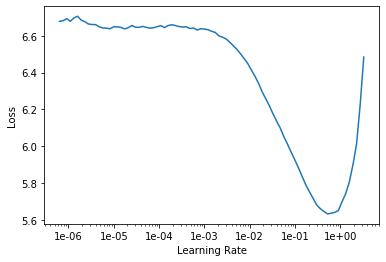

In [15]:
learn.recorder.plot()

In [16]:
learn.fit_one_cycle(1, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,2.696497,2.419453,0.512192,02:12


In [17]:
learn.unfreeze()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


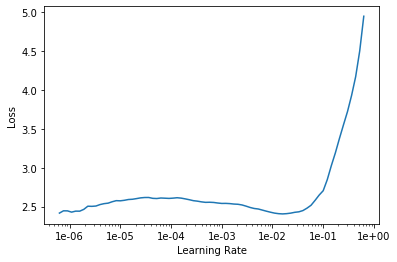

In [18]:
learn.recorder.plot()

In [19]:
learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.865602,1.942399,0.591156,02:53


In [25]:
learn.predict("Art. 1º", n_words=30)

'Art. 1º Presidente da Comissão Permanente de Disciplina , em seus afastamentos ou impedimentos legais ; \n  Processo SEI nº 00060 - scg / 2014 -'

In [21]:
learn.save_encoder('from_scratch_enc')

In [8]:
data_clas = load_data('.', 'data_clas_export.pkl', bs=8)

In [9]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('from_scratch_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (384 items)
x: TextList
xxbos o xxup diretor - xxup geral xxup do xxup departamento xxup de xxup trânsito xxup do xxup distrito xxup federal , no uso da 
  atribuição prevista no art . 3º , do xxmaj decreto nº 39.002 , de 24 de abril de 2018 , que regulamenta os arts . 44 
  e 45 da xxmaj lei xxmaj complementar nº 840 , de 23 de dezembro de 2011 , e conforme xxmaj processo xxup sei nº 00055- 
  xxunk / 2018 - 94 , resolve : xxup designar xxup juliana xxup maria xxup xxunk , xxmaj agente de xxmaj trânsito , matrícula 
  xxunk - 8 , para substituir xxup xxunk xxup douglas xxup correa , xxmaj agente de xxmaj trânsito , matrícula xxunk - 4 , xxunk , 
  símbolo xxup cne-06 , da xxmaj corregedoria , do xxmaj detran / xxup df , nos períodos de 07 a 26 / 01 / 2019 e 01 a 10 / 07 / 2019 , por 
  motivo de férias do titular . 
  xxup fabrício xxup lima xxup de xxup andrade xxup moura,xxbos xxup processo : 00150 - xxunk / 2018 - 72 ; xxup nota 

In [10]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


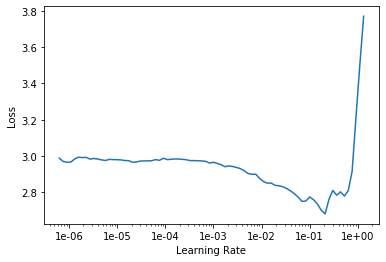

In [11]:
learn.recorder.plot()

In [12]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.370471,2.146120,0.447917,00:55


In [13]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(5e-3/2., 5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,1.822999,1.477755,0.614583,00:57


In [14]:
learn.unfreeze()
learn.fit_one_cycle(1, slice(2e-3/100, 2e-3))

epoch,train_loss,valid_loss,accuracy,time


RuntimeError: CUDA out of memory. Tried to allocate 46.00 MiB (GPU 0; 1.95 GiB total capacity; 1.15 GiB already allocated; 2.81 MiB free; 76.86 MiB cached)